In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Load the dataset

In [2]:
true_df = pd.read_csv('/content/true1.csv', encoding='latin-1')
fake_df = pd.read_csv('/content/fake1.csv', encoding='latin-1')

Add label

In [3]:
true_df['label'] = 'true'
fake_df['label'] = 'fake'

print only first 100 data

In [4]:
true_df = true_df.head(100)
print(true_df.head())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date label  
0  December 31, 2017   true  
1  December 29, 2017   true  
2  December 31, 2017   true  
3  December 30, 2017   true  
4  December 29, 2017   true  


In [5]:
fake_df = fake_df.head(100)
print(fake_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama??s Na...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  fake  
1  December 31, 2017  fake  
2  December 30, 2017  fake  
3  December 29, 2017  fake  
4  December 25, 2017  fake  


Concatenate Dataframe

In [6]:
df = pd.concat([true_df, fake_df])

Encode labels

In [7]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

Split data

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

Use DistilBERT's tokenizer to process the text

In [9]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenize function

In [10]:
import torch
def tokenize_data(texts, labels, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    ), torch.tensor(labels.tolist())

tokenize train and test data

In [11]:
train_encodings, train_labels = tokenize_data(train_df['text'], train_df['label'], max_length=128)
test_encodings, test_labels = tokenize_data(test_df['text'], test_df['label'], max_length=128)

prepate dataloader for efficient batching

In [12]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

dataloader

In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Load DistilBERT with a classification head

In [27]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define optimizer and loss function

In [15]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train the model

In [16]:
from tqdm.notebook import tqdm
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [18]:
for epoch in range(3):
    avg_loss = train(model, train_loader, optimizer)
    print(f'Epoch {epoch+1} - Loss: {avg_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.4421913005411625


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.030394243868067862


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.005000166851095856


Evaluate model performance

In [19]:
from sklearn.metrics import accuracy_score, f1_score
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, preds), f1_score(true_labels, preds)


evaluate on test set

In [20]:
accuracy, f1 = evaluate(model, test_loader)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 1.0
F1 Score: 1.0


classify news articles

In [24]:
def classify_news(article_text, model, tokenizer):
    model.eval()
    inputs = tokenizer(
        article_text,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    label = "FAKE" if prediction == 0 else "REAL"
    return label

In [28]:
new_article = "Scientists have discovered a new type of black hole that defies all known physics."
result = classify_news(new_article, model, tokenizer)
print(f"The news article is classified as: {result}")

The news article is classified as: REAL


In [29]:
print(classify_news("Breaking: Government confirms aliens have landed on Earth!", model, tokenizer))
print(classify_news("The latest economic report shows strong job growth and recovery.", model, tokenizer))

REAL
FAKE


take random arctical and predict and classify

In [32]:
import random

test_texts = test_df['text']

random_index = random.randint(0, len(test_texts) - 1)
random_article = test_texts.iloc[random_index]
actual_label = test_labels[random_index].item()

predicted_label = classify_news(random_article, model, tokenizer)

true_label_str = "REAL" if actual_label == 1 else "FAKE"
print(f"Random Article: {random_article}")
print(f"Actual Label: {true_label_str}")
print(f"Predicted Label: {predicted_label}")


Random Article: While on the campaign trail, candidate Donald Trump, a former reality show star, repeatedly mocked Sen. Marco Rubio for that time he drank water on the stage. Trump mocked Rubio at rallies about that and on Twitter, too. As they say, with this guy, there really is a tweet for everything. Trump did this after he kicked off his day blasting that  loser  network CNN, the  failing  New York Times and demanded a  thank you  from the UCLA basketball players who arrived in the states after being released from China. Then he summarized his trip to Asia, declaring it to be  the longest visit to the region by an American president in more than a quarter of a century.  He added that  America is back and the future has never looked better.  Then he seemed to have difficulty breathing and paused for water.Here is Trump doing that think he disparaged Rubio for doing:more proof that we're living in a simulation pic.twitter.com/7fGMxvRKUj  kevin driscoll (@kevndriscoll) November 15, 20

visualization of accuracy and F1 score metrics

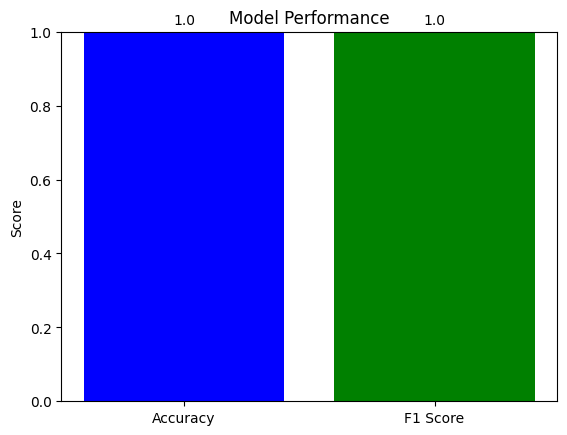

In [26]:
import matplotlib.pyplot as plt

accuracy = 1.0
f1 = 1.0

metrics = ['Accuracy', 'F1 Score']
values = [accuracy, f1]

plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim([0, 1])

for i, v in enumerate(values):
    plt.text(i, v + 0.02, str(round(v, 2)), ha='center', color='black')

plt.show()